---
title: "Data Science Design Pattern for Student Score Modelling"
author: "Microsoft"
output: 
    rmarkdown::html_vignette:
        toc: true

vignette: >
  %\VignetteIndexEntry{Vignette Title}
  %\VignetteEngine{knitr::rmarkdown}
  %\VignetteEncoding{UTF-8}
---

In [1]:

knitr::opts_chunk$set(fig.width = 6,
                      fig.height = 4,
                      fig.align='center',
                      dev = "png")


# Introducation

Welcome to the Data Science Design Pattern for Student Score Modelling. This pattern provides a starting point for the data scientist exploring a new dataset. By no means is it the end point of the data science journey. The pattern is under regular revision and improvement and is provided as is. 

We now introduce a generic pattern for building mixed effect regression models using R.

# Pre-configuration

We load the R packages required for modelling.

In [2]:
########################################################################
# R SETUP

# Load required packages from local library into R.

library(magrittr)     # Data pipelines: %>% %T>% %<>%.
library(stringi)      # String operator: %s+%.
library(rattle)       # Evaluate using riskchart().
library(ggplot2)      # Visually evaluate performance.
library(lme4)         # Linear mixed effect model.

Rattle: A free graphical interface for data mining with R.
Version 4.1.0 Copyright (c) 2006-2015 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.
Loading required package: Matrix


# Step 4.4: Re-load Dataset

In the Data template we loaded the studentScoreAUS dataset, processed it, and saved it to file. Here we re-load the dataset and review its contents.

In [3]:
########################################################################
# DATA INGESTION

# Identify the dataset.

dsname <- "studentScoreAUS"

# Identify the dataset to load.

fpath  <- "data"
dsdate <- "_" %s+% "20161215"

# Filename of the saved dataset.

dsrdata <-
  file.path(fpath, dsname %s+% dsdate %s+% ".RData") %T>% 
  print()

# Load the R objects from file and list them.

load(dsrdata) %>% print()

# Review the metadata.

dsname
dspath
dsdate
nobs
vars
target
id
ignore
omit

[1] "data/studentScoreAUS_20161215.RData"
 [1] "ds"     "dsname" "dspath" "dsdate" "nobs"   "vars"   "target" "id"    
 [9] "ignore" "omit"   "inputi" "inputs" "numi"   "numc"   "cati"   "catc"  


[1] "studentScoreAUS"

[1] "C:/Users/zhouf/Documents/Revolution Analytics/Projects/Education2/Demo/studentScoreAUS_20161215.csv"

[1] "_20161215"

[1] 1222

[1] "score"             "indigenous"        "english_language" 
[4] "father_occupation" "mother_occupation" "attendance_rate"  
[7] "guardian"          "level"

[1] "score"

[1] "student_id"  "school_code" "test_year"

[1] "student_id"  "school_code" "test_year"

NULL

# Step 4.5: Prepare - Formula to Describe the Goal

After re-loading the data into memory, we continue on from the Data template where we had Steps 1, 2, and 3 and the beginnings of Step 4 of a data mining process.

The next step is to describe the model to be built by way of writing a formula to capture our intent. The formula describes the model to be built as being constructed to predict the target variable based on the other (suitable) variables available in the dataset.

In this particular case, we address the problem as a regression problem, but taking random effects for student and school into account. Statistically speaking, parameters associated with the particular levels of a covariate in a model are sometimes called the “effects” of the levels. If the set of possible levels of the covariate is fixed and reproducible we model the covariate using fixed-effects parameters. If the levels that we observed represent a random sample from the set of all possible levels we incorporate random effects in the model. For example, here the levels of the english_language covariate, true and false, are fixed. If we consider data from another school or we incorporate scores from earlier tests, we will not change those levels. On the other hand, the students whose scores we observed would generally be regarded as a sample from the set of all possible students whom we could have observed. Adding more data, either from more school or from results on previous or subsequent tests, will increase the number of distinct levels of the student identifier. Understanding this point, we will need a formula for mixed effects regression model, where the two identifiers student_id and school_code are specified as random effects and other covariates are treated as fixed effects. The notation used to express this is to name the target (score), followed by a tilde (~), and followed by an addition of crossed random effects represented by (1|student_id)+(1|school_code) and fixed effects.

In [4]:
########################################################################
# PREPARE FOR MODELLING

# Formula for modelling.
rvars <- c("student_id", "school_code")
reffect <- "(1|" %s+% rvars[1] %s+% ")+(1|" %s+% rvars[2] %s+% ")" %T>% print()

[1] "(1|student_id)+(1|school_code)"


In [5]:
fvars <- setdiff(vars, target) 
feffect <- paste(fvars, collapse="+") %T>% print()

[1] "indigenous+english_language+father_occupation+mother_occupation+attendance_rate+guardian+level"


In [6]:
form <- as.formula(target %s+% "~" %s+% reffect %s+% "+" %s+% feffect) %T>% print()

score ~ (1 | student_id) + (1 | school_code) + indigenous + english_language + 
    father_occupation + mother_occupation + attendance_rate + 
    guardian + level


# Step 5: Build - Mixed Effect Regression Model

Now we build a mixed effect regression model using the function 'lmer' from the R package 'lme4'.

In [7]:
# Initialise random numbers for repeatable results.

seed <- 123
set.seed(seed)

########################################################################
# TRAIN MODEL

# Train a mixed effect regression model.
m.lmer <- lmer(form, data=ds)

model <- m.lmer
mtype <- "lmer"
mdesc <- "Linear Mixed Effect Model"

# Basic model summary.

model

Linear mixed model fit by REML ['lmerMod']
Formula: 
score ~ (1 | student_id) + (1 | school_code) + indigenous + english_language +  
    father_occupation + mother_occupation + attendance_rate +  
    guardian + level
   Data: ds
REML criterion at convergence: 13566.48
Random effects:
 Groups      Name        Std.Dev.
 student_id  (Intercept) 74.22   
 school_code (Intercept) 13.98   
 Residual                47.14   
Number of obs: 1222, groups:  student_id, 380; school_code, 2
Fixed Effects:
              (Intercept)             indigenoustrue  
                 314.9855                   -48.4786  
     english_languagetrue    father_occupationhealth  
                  19.2053                   -24.0325  
   father_occupationother  father_occupationservices  
                 -28.3204                   -30.4842  
 father_occupationteacher    mother_occupationhealth  
                   4.1558                    51.3506  
   mother_occupationother  mother_occupationservices  
     

The printed display of the model fit with lmer() has four major sections: a description of the model that was fit, some statistics characterizing the model fit, a summary of properties of the random effects and a summary of the fixed-effects parameter estimates. 

The description section states that this is a linear mixed model in which the parameters have been estimated as those that minimize the REML (Residual Maximum Likelihood) criterion. The formula and data arguments are displayed for later reference. 

The statistic describing the model fit is the value of the REML criterion, which is equal to 13566.48. This criterion is usually used to describe the model fit, where crossed random effects (1|r1)+(1|r2) exist. If your random effects are nested (1|r1/r2), or you have only one random effect, and if your data are balanced, you can use ML (Maximum Likelihood) criterion, which can be obtained by specifying the argument REML = FALSE in the lmer() function. 

The third section is the table of estimates of parameters associated with the random effects. There are three sources of variability in the model we have fit, a student-to-student variability, a school-to-school variability and the residual or per-observation variability. These variabilities are measured by standard deviations. The value of the standard deviation for random effect, like student or school, is important, because if it is indistinguishable from zero, then this random effect probably doesn't matter and you can delete it or go ahead and do a regular linear model instead. Here, we can actually delete the random effect for school.

The last section shows the estimates of the fixed effect parameters. For example, the estimated parameter of english_languagetrue equal to 19.2053 means that the student who is an english native speaker has a higher probability in achieving a better test score.

# Step 6: Evaluate 

We do model diagonosis by checking a set of goodness-of-fit measures, for example, residual plot and R-square. A residual plot without any trend or pattern and a R-square equal to 83% as shown in the below output roughly indicate a good initial model.

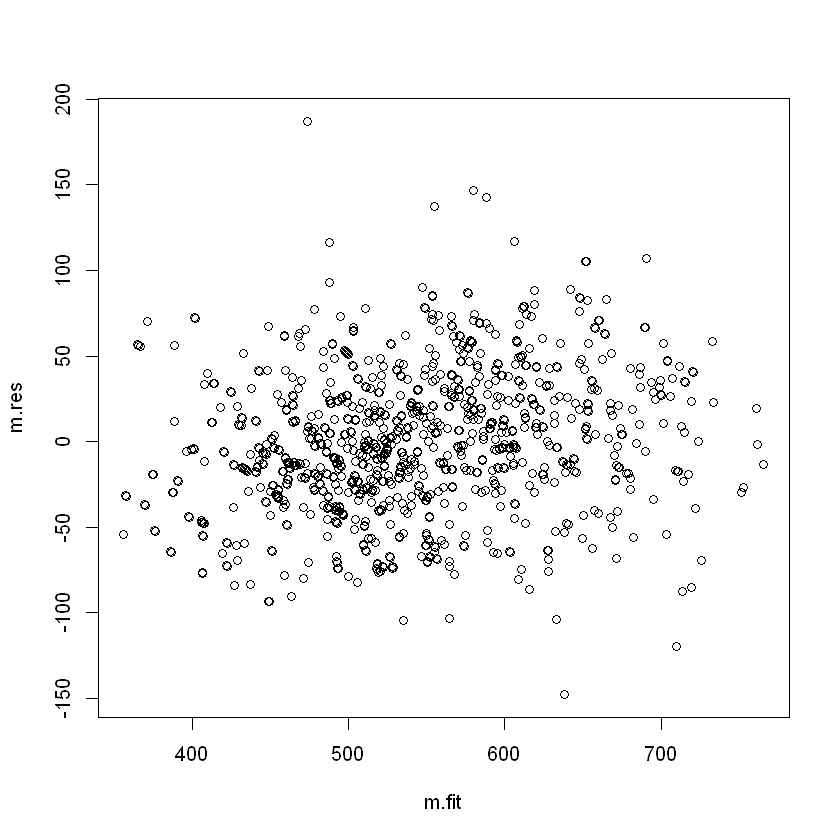

In [9]:
########################################################################
# DIAGONOSE MODEL

# Draw residual plot.

m.res <- resid(model)
m.fit <- fitted(model)
plot(m.res ~ m.fit)

In [10]:
# Calculate R-square.

cor(m.fit, model@frame$score)^2

[1] 0.8290851

In [11]:
# Compare impact of effects.

summary(model, cor=FALSE)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
	 vcov(obj)	 if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: 
score ~ (1 | student_id) + (1 | school_code) + indigenous + english_language +  
    father_occupation + mother_occupation + attendance_rate +  
    guardian + level
   Data: ds

REML criterion at convergence: 13566.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1363 -0.5455 -0.0325  0.5519  3.9712 

Random effects:
 Groups      Name        Variance Std.Dev.
 student_id  (Intercept) 5508.7   74.22   
 school_code (Intercept)  195.5   13.98   
 Residual                2221.9   47.14   
Number of obs: 1222, groups:  student_id, 380; school_code, 2

Fixed effects:
                          Estimate Std. Error t value
(Intercept)               314.9855    61.5294   5.119
indigenoustrue            -48.4786    33.5530  -1.445
english_languagetrue       19.2053    19.6396   0.978
father_occupationhealth   -24.0325    28.4770  -0.844
father_occupationother    -28.3204    20.8976  -1.355
father_occupationservices -30.4842  

# Step 7: Predict

We pre-define the function lmeForecast() that we will use for forecasting. Within this function, we select the data which contains only final test score for each student and then use the trained model in Step 5 to predict on the selected data without taking student effect into account. The design of this function benefits in comparing overall student test scores across school corhorts.

In [12]:
########################################################################
# FORECAST

# We define the function that we will use for forecasting.

lmeForecast <- function(model, data) 
{
  # variables in the functions: student_id, school_code, test_year, level, score.
  # i.e., id, target, level
  
  require(dplyr)
  require(lme4)
  data <- data %>%
    arrange(student_id, level) %>%
    group_by(student_id) %>%
    filter(row_number() == n(), # keep final test result for each student
           level != "9") %>%  # but only if student is not already in year 9
    do({
      yearLevel <- as.numeric(as.character(.$level))[1]
      year <- as.numeric(as.character(.$test_year))
      newRows <- (9 - yearLevel)/2 + 1
      out <- .[rep(1, newRows), ]
      yearLevel <- seq(yearLevel, to=9, by=2)
      out$test_year <- year + yearLevel - yearLevel[1]
      out$level <- factor(yearLevel, levels=c(3, 5, 7, 9))
      out
    })
  dim
  
  # get predicted scores without student effect
  
  data <- data.frame(data,
                     pred=predict(model, data, allow.new.levels=TRUE, re.form=~(1|school_code)))
  
  # adjust predicted scores based on most recent test result, keep only forecasted rows
  
  left_join(data,
            data %>%
              group_by(student_id) %>%
              summarise(adj=(score - pred)[1], n=n()),
            by="student_id") %>%
    mutate(predictedScore=pred + adj, score=NA) %>%
    group_by(student_id) %>%
    select(-pred, -adj, -n) %>%
    filter(row_number() != 1)
}

Finally, we can use the pre-defined function lmeForecast() to predict on a subset of observations in specific corhort and review the forecasting results.

In [13]:
# Select observations in specific corhort.

testcohort <- subset(ds, school_code == "301")

# Forecast for the data in the corhort.

testcohort.fcast <- lmeForecast(model, testcohort)

# Review forecasting result.

head(testcohort.fcast)

tail(testcohort.fcast)

summary(testcohort.fcast)

Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



student_id,indigenous,english_language,father_occupation,mother_occupation,attendance_rate,guardian,level,score,test_year,school_code,predictedScore
s00001,false,false,other,at_home,0.9600000,mother,5,NA,2011,301,547.4488
s00001,false,false,other,at_home,0.9600000,mother,7,NA,2013,301,485.5465
s00001,false,false,other,at_home,0.9600000,mother,9,NA,2015,301,547.4016
s00009,false,true,other,other,0.8800000,father,9,NA,2015,301,738.8551
s00014,false,true,services,other,1.0000000,father,9,NA,2015,301,570.8551
s00016,false,true,services,at_home,0.9866667,mother,9,NA,2015,301,701.8551


student_id,indigenous,english_language,father_occupation,mother_occupation,attendance_rate,guardian,level,score,test_year,school_code,predictedScore
s00320,false,true,other,services,0.9466667,mother,9,NA,2015,301,485.8551
s00322,false,true,other,teacher,0.9133333,mother,9,NA,2015,301,576.8551
s00331,false,true,other,other,1.0000000,mother,9,NA,2015,301,511.8551
s00333,false,true,other,other,0.9866667,mother,9,NA,2015,301,479.8551
s00339,false,true,at_home,services,0.9600000,mother,9,NA,2015,301,497.8551
s00340,false,true,at_home,services,0.8933333,mother,9,NA,2015,301,572.8551


  student_id        indigenous english_language father_occupation
 Length:94          false:93   false: 5         at_home : 2      
 Class :character   true : 1   true :89         health  : 5      
 Mode  :character                               other   :57      
                                                services:24      
                                                teacher : 6      
                                                                 
 mother_occupation attendance_rate    guardian  level   score        
 at_home :15       Min.   :0.7400   father:23   3: 0   Mode:logical  
 health  : 8       1st Qu.:0.9333   mixed : 0   5: 5   NA's:94       
 other   :36       Median :0.9600   mother:67   7:18                 
 services:21       Mean   :0.9472   other : 4   9:71                 
 teacher :14       3rd Qu.:0.9867                                    
                   Max.   :1.0000                                    
   test_year    school_code predictedScore 
 Min

# Step 8: Finish Up - Save Model

We save the model, together with the dataset and other variables, into a binary R file.

In [14]:
dname <- "models"
if (! file.exists(dname)) dir.create(dname)
time.stamp <- format(Sys.time(), "%Y%m%d_%H%M%S")
fstem <- paste(dsname, mtype, time.stamp, sep="_")
(fname <- file.path(dname, sprintf("%s.RData", fstem)))

[1] "models/studentScoreAUS_lmer_20161220_160031.RData"

In [15]:
save(ds, dsname, vars, target, ignore,
form, nobs, seed, model, mtype, 
file=fname)

We can then load this later and replicate the process.

In [16]:
(load(fname))

[1] "ds"     "dsname" "vars"   "target" "ignore" "form"   "nobs"   "seed"  
 [9] "model"  "mtype"

Note that by using generic variable names we can load different model files and perform common operations on them without changing the names within a script. However, do note that each time we load such a saved model file we overwrite any other variables of the same name.